<a href="https://colab.research.google.com/github/DodgerM1127/Data-Mining-class/blob/main/Applied_Data_Mining_with_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.metrics import (mean_squared_error, r2_score, mean_absolute_error,
                             accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, classification_report, confusion_matrix)
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Load wine quality dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
wine_df = pd.read_csv(url, sep=';')

# Create engineered features from Part 2
wine_df['free_sulfur_ratio'] = wine_df['free sulfur dioxide'] / (wine_df['total sulfur dioxide'] + 0.001)
wine_df['acid_ratio'] = wine_df['fixed acidity'] / (wine_df['volatile acidity'] + 0.001)
wine_df['alcohol_density'] = wine_df['alcohol'] * wine_df['density']
wine_df['log_chlorides'] = np.log1p(wine_df['chlorides'])

# Binary classification target
wine_df['good_wine'] = (wine_df['quality'] >= 7).astype(int)

print(f"Dataset loaded with engineered features: {wine_df.shape}")
print(f"Target distribution (quality): {wine_df['quality'].min()}-{wine_df['quality'].max()}")
print(f"Good wine percentage: {wine_df['good_wine'].mean()*100:.1f}%")

Dataset loaded with engineered features: (1599, 17)
Target distribution (quality): 3-8
Good wine percentage: 13.6%


In [2]:
from sklearn.metrics import (mean_squared_error, mean_absolute_error,
                             r2_score, mean_absolute_percentage_error)

# Prepare regression data
X = wine_df.drop(['quality', 'good_wine'], axis=1)
y = wine_df['quality']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model
model = Ridge(alpha=1.0)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

# Calculate all regression metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print("REGRESSION METRICS COMPARISON")
print("=" * 50)
print(f"\nMean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2%}")

print("\nMetric Interpretations:")
print(f"  - RMSE of {rmse:.2f} means predictions are off by ~{rmse:.2f} quality points on average")
print(f"  - MAE of {mae:.2f} is the average absolute error")
print(f"  - R² of {r2:.2f} means {r2*100:.1f}% of variance is explained")

REGRESSION METRICS COMPARISON

Mean Squared Error (MSE): 0.3890
Root Mean Squared Error (RMSE): 0.6237
Mean Absolute Error (MAE): 0.5019
R² Score: 0.4047
Mean Absolute Percentage Error (MAPE): 8.96%

Metric Interpretations:
  - RMSE of 0.62 means predictions are off by ~0.62 quality points on average
  - MAE of 0.50 is the average absolute error
  - R² of 0.40 means 40.5% of variance is explained


In [4]:
# Demonstrate how outlier predictions affect different metrics
np.random.seed(42)

# Simulate two models with different error patterns
y_test_sample = np.array([5, 5, 6, 6, 7, 7, 5, 6, 5, 7])

# Model A: Small consistent errors
y_pred_a = np.array([5.3, 5.4, 5.8, 6.2, 6.7, 6.8, 5.2, 5.9, 5.1, 6.9])

# Model B: Mostly accurate but one big outlier
y_pred_b = np.array([5.0, 5.0, 6.0, 6.0, 7.0, 7.0, 5.0, 6.0, 5.0, 4.0])  # Last one is way off

print("TWO MODELS WITH DIFFERENT ERROR PATTERNS")
print("=" * 50)
print("\nModel A (consistent small errors):")
print(f"  MSE: {mean_squared_error(y_test_sample, y_pred_a):.4f}")
print(f"  MAE: {mean_absolute_error(y_test_sample, y_pred_a):.4f}")

print("\nModel B (one big outlier):")
print(f"  MSE: {mean_squared_error(y_test_sample, y_pred_b):.4f}")
print(f"  MAE: {mean_absolute_error(y_test_sample, y_pred_b):.4f}")

print("\nInsight:")
print("  - MSE penalizes large errors quadratically")
print("  - MAE treats all errors equally")
print("  - Model B has better MAE despite one large error")

TWO MODELS WITH DIFFERENT ERROR PATTERNS

Model A (consistent small errors):
  MSE: 0.0530
  MAE: 0.2100

Model B (one big outlier):
  MSE: 0.9000
  MAE: 0.3000

Insight:
  - MSE penalizes large errors quadratically
  - MAE treats all errors equally
  - Model B has better MAE despite one large error


In [5]:
# Prepare classification data
X = wine_df.drop(['quality', 'good_wine'], axis=1)
y = wine_df['good_wine']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train logistic regression
log_model = LogisticRegression(random_state=42, max_iter=1000)
log_model.fit(X_train_scaled, y_train)
y_pred = log_model.predict(X_test_scaled)
y_prob = log_model.predict_proba(X_test_scaled)[:, 1]

# All classification metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print("CLASSIFICATION METRICS")
print("=" * 50)
print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

print("\nMetric Interpretations:")
print(f"  - Accuracy: {accuracy*100:.1f}% of all predictions are correct")
print(f"  - Precision: {precision*100:.1f}% of predicted 'good' wines are actually good")
print(f"  - Recall: {recall*100:.1f}% of actual 'good' wines are identified")
print(f"  - F1: Harmonic mean of precision and recall")
print(f"  - ROC-AUC: Probability that model ranks positive higher than negative")

CLASSIFICATION METRICS

Accuracy: 0.8906
Precision: 0.6818
Recall: 0.3488
F1 Score: 0.4615
ROC-AUC: 0.8971

Metric Interpretations:
  - Accuracy: 89.1% of all predictions are correct
  - Precision: 68.2% of predicted 'good' wines are actually good
  - Recall: 34.9% of actual 'good' wines are identified
  - F1: Harmonic mean of precision and recall
  - ROC-AUC: Probability that model ranks positive higher than negative


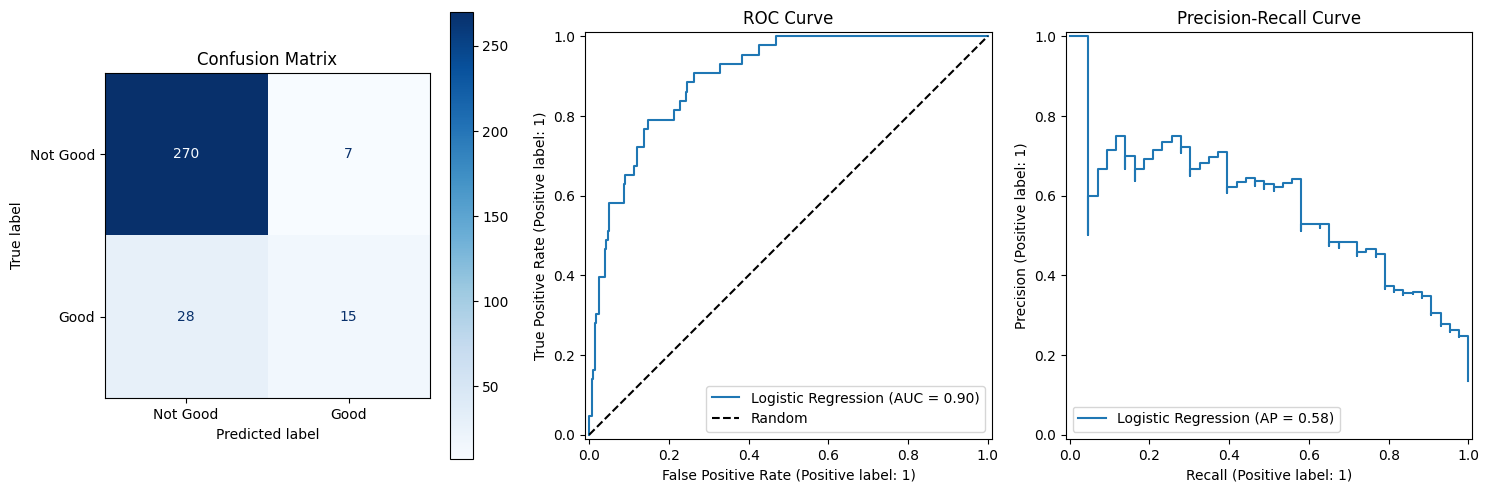


Confusion Matrix Breakdown:
  True Negatives (correctly predicted Not Good): 270
  False Positives (predicted Good, actually Not Good): 7
  False Negatives (predicted Not Good, actually Good): 28
  True Positives (correctly predicted Good): 15


In [6]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=['Not Good', 'Good'],
    ax=axes[0],
    cmap='Blues'
)
axes[0].set_title('Confusion Matrix')

# ROC Curve
RocCurveDisplay.from_predictions(
    y_test, y_prob,
    ax=axes[1],
    name='Logistic Regression'
)
axes[1].plot([0, 1], [0, 1], 'k--', label='Random')
axes[1].set_title('ROC Curve')
axes[1].legend()

# Precision-Recall Curve
PrecisionRecallDisplay.from_predictions(
    y_test, y_prob,
    ax=axes[2],
    name='Logistic Regression'
)
axes[2].set_title('Precision-Recall Curve')

plt.tight_layout()
plt.show()

# Confusion matrix interpretation
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
print("\nConfusion Matrix Breakdown:")
print(f"  True Negatives (correctly predicted Not Good): {tn}")
print(f"  False Positives (predicted Good, actually Not Good): {fp}")
print(f"  False Negatives (predicted Not Good, actually Good): {fn}")
print(f"  True Positives (correctly predicted Good): {tp}")

In [7]:
from sklearn.model_selection import cross_val_score, KFold

# Prepare data for regression
X = wine_df.drop(['quality', 'good_wine'], axis=1)
y = wine_df['quality']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-Fold CV with Ridge regression
model = Ridge(alpha=1.0)

# 5-fold cross-validation
cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='r2')

print("5-FOLD CROSS-VALIDATION RESULTS")
print("=" * 50)
print(f"\nIndividual fold R² scores: {cv_scores.round(4)}")
print(f"Mean R²: {cv_scores.mean():.4f}")
print(f"Std R²: {cv_scores.std():.4f}")
print(f"95% CI: [{cv_scores.mean() - 1.96*cv_scores.std():.4f}, {cv_scores.mean() + 1.96*cv_scores.std():.4f}]")

# Compare to single split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)
single_split_r2 = r2_score(y_test, model.predict(X_test))
print(f"\nSingle train/test split R²: {single_split_r2:.4f}")
print(f"CV mean is {'higher' if cv_scores.mean() > single_split_r2 else 'lower'} than single split")

5-FOLD CROSS-VALIDATION RESULTS

Individual fold R² scores: [0.1256 0.3113 0.3444 0.3707 0.2703]
Mean R²: 0.2845
Std R²: 0.0862
95% CI: [0.1155, 0.4535]

Single train/test split R²: 0.4046
CV mean is lower than single split


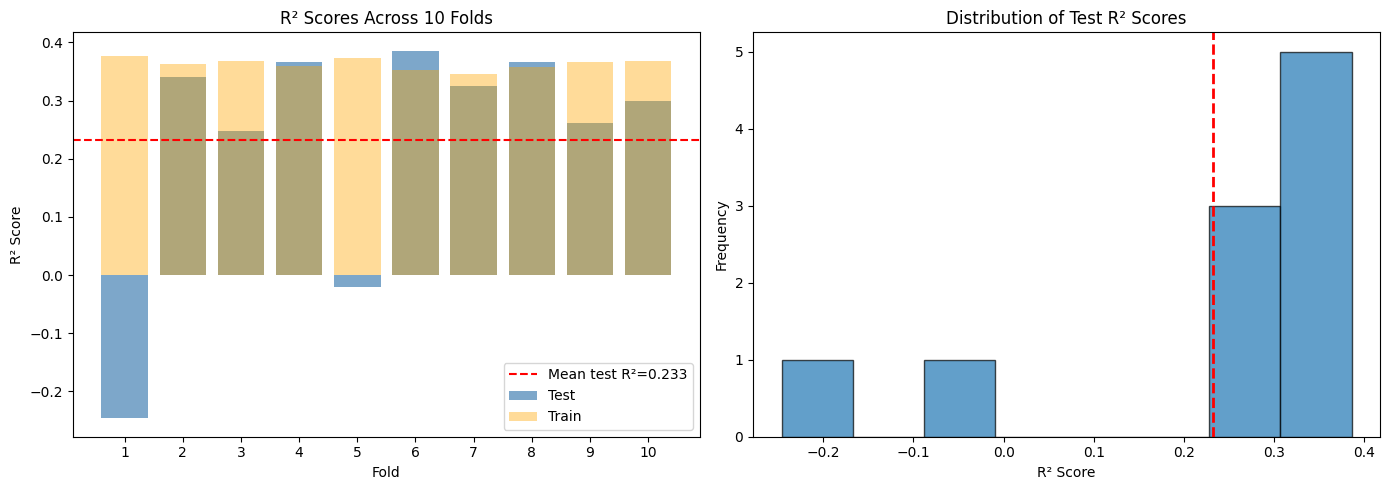

Train-Test Gap: 0.1302
(Large gap may indicate overfitting)


In [8]:
from sklearn.model_selection import cross_validate

# Get more detailed CV results
cv_results = cross_validate(
    model, X_scaled, y, cv=10,
    scoring=['r2', 'neg_mean_squared_error'],
    return_train_score=True
)

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# R² scores across folds
folds = range(1, 11)
axes[0].bar(folds, cv_results['test_r2'], alpha=0.7, label='Test', color='steelblue')
axes[0].bar(folds, cv_results['train_r2'], alpha=0.4, label='Train', color='orange')
axes[0].axhline(y=cv_results['test_r2'].mean(), color='red', linestyle='--',
                label=f'Mean test R²={cv_results["test_r2"].mean():.3f}')
axes[0].set_xlabel('Fold')
axes[0].set_ylabel('R² Score')
axes[0].set_title('R² Scores Across 10 Folds')
axes[0].legend()
axes[0].set_xticks(folds)

# Distribution of scores
axes[1].hist(cv_results['test_r2'], bins=8, edgecolor='black', alpha=0.7)
axes[1].axvline(x=cv_results['test_r2'].mean(), color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('R² Score')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Test R² Scores')

plt.tight_layout()
plt.show()

print(f"Train-Test Gap: {cv_results['train_r2'].mean() - cv_results['test_r2'].mean():.4f}")
print("(Large gap may indicate overfitting)")

In [9]:
from sklearn.model_selection import StratifiedKFold

# Classification data
X = wine_df.drop(['quality', 'good_wine'], axis=1)
y = wine_df['good_wine']
X_scaled = StandardScaler().fit_transform(X)

# Compare regular KFold vs StratifiedKFold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

log_model = LogisticRegression(random_state=42, max_iter=1000)

# Regular KFold
kfold_scores = cross_val_score(log_model, X_scaled, y, cv=kfold, scoring='roc_auc')

# Stratified KFold
stratified_scores = cross_val_score(log_model, X_scaled, y, cv=stratified_kfold, scoring='roc_auc')

print("KFOLD vs STRATIFIED KFOLD")
print("=" * 50)
print(f"\nRegular KFold:")
print(f"  Scores: {kfold_scores.round(4)}")
print(f"  Mean: {kfold_scores.mean():.4f} ± {kfold_scores.std():.4f}")

print(f"\nStratified KFold:")
print(f"  Scores: {stratified_scores.round(4)}")
print(f"  Mean: {stratified_scores.mean():.4f} ± {stratified_scores.std():.4f}")

print("\nStratified KFold typically has lower variance for imbalanced classes")

KFOLD vs STRATIFIED KFOLD

Regular KFold:
  Scores: [0.8954 0.8743 0.857  0.8871 0.8709]
  Mean: 0.8769 ± 0.0133

Stratified KFold:
  Scores: [0.8828 0.8799 0.9009 0.8309 0.8979]
  Mean: 0.8785 ± 0.0251

Stratified KFold typically has lower variance for imbalanced classes


MODEL COMPARISON VIA CROSS-VALIDATION
            Model  Mean R²   Std R²   Min R²   Max R²
Linear Regression 0.283716 0.088190 0.120368 0.371471
    Ridge (α=1.0) 0.284469 0.086233 0.125616 0.370712
    Lasso (α=0.1) 0.240725 0.053591 0.157606 0.314561
   Ridge (α=10.0) 0.285770 0.085093 0.129426 0.369771


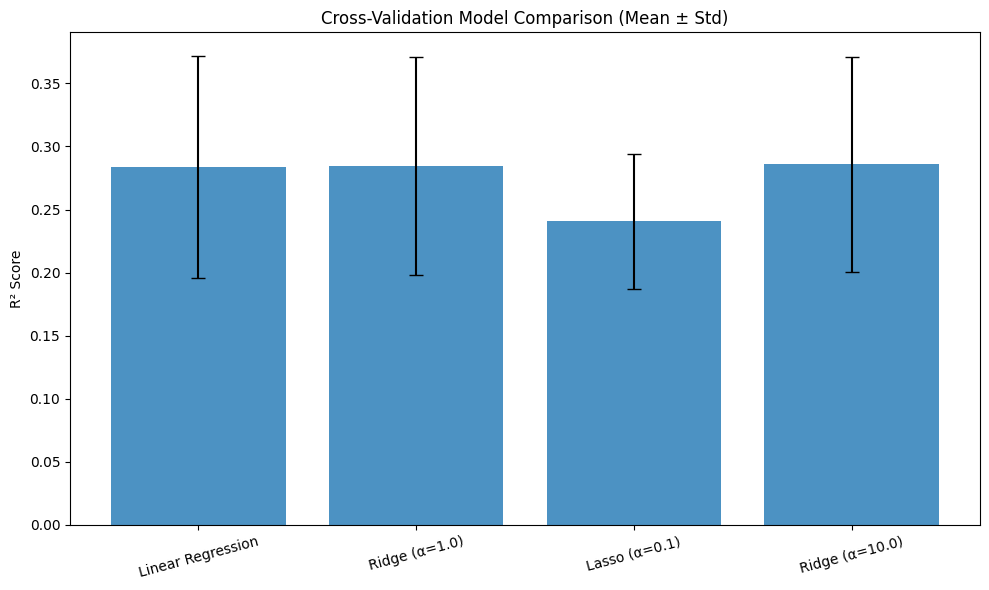

In [10]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

# Compare multiple models using CV
X = wine_df.drop(['quality', 'good_wine'], axis=1)
y = wine_df['quality']
X_scaled = StandardScaler().fit_transform(X)

models = {
    'Linear Regression': LinearRegression(),
    'Ridge (α=1.0)': Ridge(alpha=1.0),
    'Lasso (α=0.1)': Lasso(alpha=0.1),
    'Ridge (α=10.0)': Ridge(alpha=10.0),
}

cv_comparison = []
for name, model in models.items():
    scores = cross_val_score(model, X_scaled, y, cv=5, scoring='r2')
    cv_comparison.append({
        'Model': name,
        'Mean R²': scores.mean(),
        'Std R²': scores.std(),
        'Min R²': scores.min(),
        'Max R²': scores.max()
    })

cv_df = pd.DataFrame(cv_comparison)
print("MODEL COMPARISON VIA CROSS-VALIDATION")
print("=" * 60)
print(cv_df.to_string(index=False))

# Visualize
plt.figure(figsize=(10, 6))
x = range(len(cv_df))
plt.bar(x, cv_df['Mean R²'], yerr=cv_df['Std R²'], capsize=5, alpha=0.8)
plt.xticks(x, cv_df['Model'], rotation=15)
plt.ylabel('R² Score')
plt.title('Cross-Validation Model Comparison (Mean ± Std)')
plt.tight_layout()
plt.show()

In [11]:
# Install xgboost if needed (run in Colab)
# !pip install xgboost

import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier

print(f"XGBoost version: {xgb.__version__}")

# Prepare data
X = wine_df.drop(['quality', 'good_wine'], axis=1)
y = wine_df['quality']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

XGBoost version: 3.1.2
Training set: (1279, 15)
Test set: (320, 15)


In [12]:
# Train basic XGBoost regressor
xgb_model = XGBRegressor(
    n_estimators=100,      # Number of trees
    max_depth=6,           # Maximum tree depth
    learning_rate=0.1,     # Step size shrinkage
    random_state=42,
    verbosity=0
)

xgb_model.fit(X_train, y_train)

# Predictions
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

# Evaluate
print("XGBOOST REGRESSION RESULTS")
print("=" * 50)
print(f"\nTraining Performance:")
print(f"  R² Score: {r2_score(y_train, y_train_pred):.4f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred)):.4f}")

print(f"\nTest Performance:")
print(f"  R² Score: {r2_score(y_test, y_test_pred):.4f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred)):.4f}")

# Compare to Ridge baseline
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(StandardScaler().fit_transform(X_train), y_train)
ridge_r2 = r2_score(y_test, ridge_model.predict(StandardScaler().fit(X_train).transform(X_test)))
print(f"\nComparison - Ridge R²: {ridge_r2:.4f}")
print(f"XGBoost improvement: {((r2_score(y_test, y_test_pred) - ridge_r2) / ridge_r2 * 100):.1f}%")

XGBOOST REGRESSION RESULTS

Training Performance:
  R² Score: 0.9178
  RMSE: 0.2313

Test Performance:
  R² Score: 0.4903
  RMSE: 0.5771

Comparison - Ridge R²: 0.4047
XGBoost improvement: 21.2%


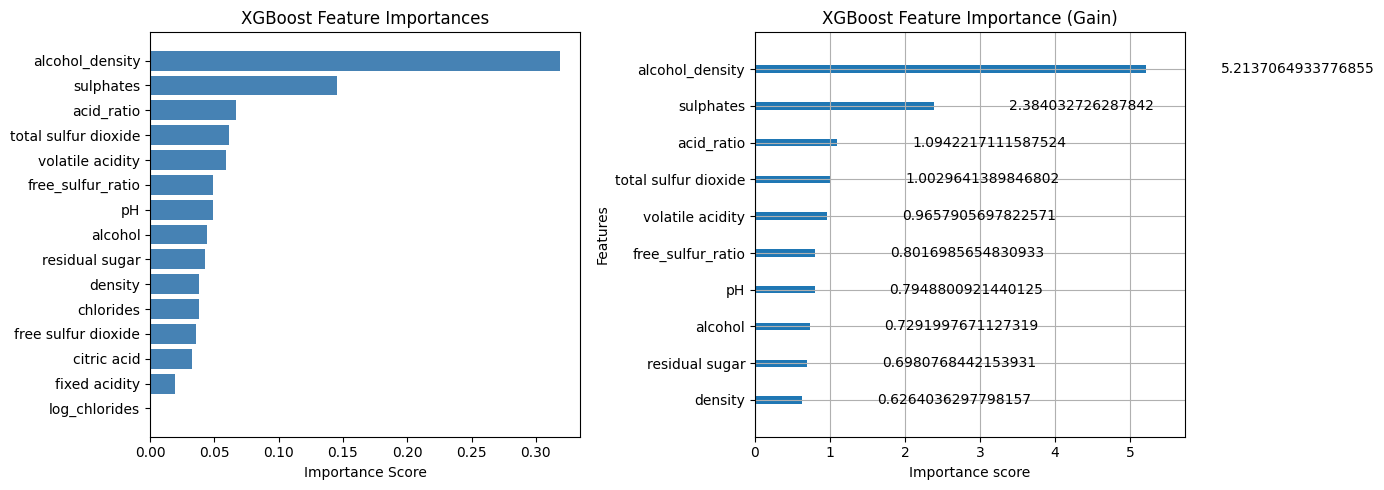

Top 5 Most Important Features:
             Feature  Importance
     alcohol_density    0.318615
           sulphates    0.145691
          acid_ratio    0.066869
total sulfur dioxide    0.061292
    volatile acidity    0.059020


In [13]:
# Get feature importances
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
axes[0].barh(importance_df['Feature'], importance_df['Importance'], color='steelblue')
axes[0].set_xlabel('Importance Score')
axes[0].set_title('XGBoost Feature Importances')
axes[0].invert_yaxis()

# Built-in XGBoost plot
xgb.plot_importance(xgb_model, ax=axes[1], max_num_features=10, importance_type='gain')
axes[1].set_title('XGBoost Feature Importance (Gain)')

plt.tight_layout()
plt.show()

print("Top 5 Most Important Features:")
print(importance_df.head().to_string(index=False))

In [14]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

# Grid search with cross-validation
xgb_base = XGBRegressor(random_state=42, verbosity=0)

# Use smaller grid for demonstration (full grid takes time)
param_grid_small = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.2]
}

grid_search = GridSearchCV(
    xgb_base,
    param_grid_small,
    cv=3,
    scoring='r2',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("\nGRID SEARCH RESULTS")
print("=" * 50)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV R²: {grid_search.best_score_:.4f}")

# Evaluate best model
best_xgb = grid_search.best_estimator_
y_pred_best = best_xgb.predict(X_test)
print(f"Test R² (best model): {r2_score(y_test, y_pred_best):.4f}")

Fitting 3 folds for each of 8 candidates, totalling 24 fits

GRID SEARCH RESULTS
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Best CV R²: 0.3974
Test R² (best model): 0.4704


In [15]:
# Classification: predict good wine
X = wine_df.drop(['quality', 'good_wine'], axis=1)
y = wine_df['good_wine']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# XGBoost classifier with class imbalance handling
xgb_clf = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=(len(y_train) - y_train.sum()) / y_train.sum(),  # Handle imbalance
    random_state=42,
    verbosity=0
)

xgb_clf.fit(X_train, y_train)

# Predictions
y_pred = xgb_clf.predict(X_test)
y_prob = xgb_clf.predict_proba(X_test)[:, 1]

print("XGBOOST CLASSIFICATION RESULTS")
print("=" * 50)
print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob):.4f}")

# Compare to logistic regression
log_model = LogisticRegression(random_state=42, max_iter=1000)
log_model.fit(StandardScaler().fit_transform(X_train), y_train)
log_prob = log_model.predict_proba(StandardScaler().fit(X_train).transform(X_test))[:, 1]
print(f"\nLogistic Regression ROC-AUC: {roc_auc_score(y_test, log_prob):.4f}")

XGBOOST CLASSIFICATION RESULTS

Accuracy: 0.9156
Precision: 0.6739
Recall: 0.7209
F1 Score: 0.6966
ROC-AUC: 0.9262

Logistic Regression ROC-AUC: 0.8971


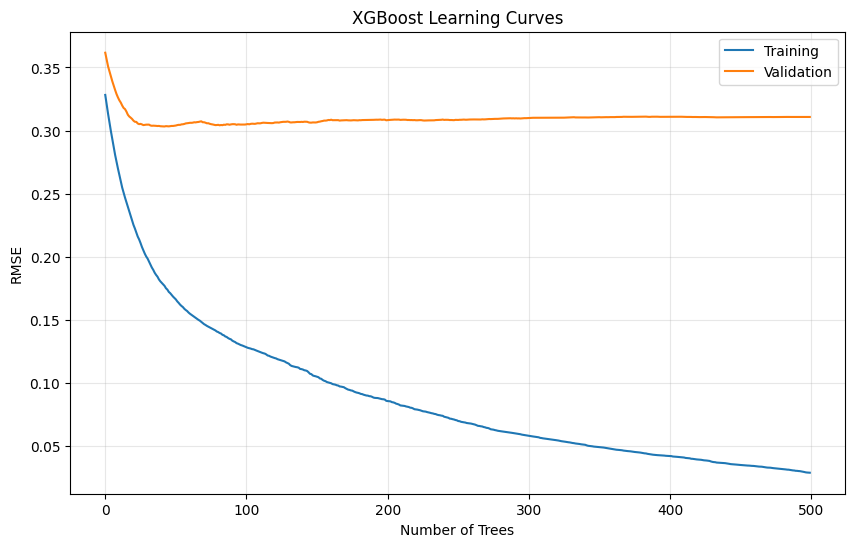

Observation: If validation error increases while training error decreases,
the model is overfitting. Use early_stopping_rounds to prevent this.


In [16]:
# Training with early stopping to prevent overfitting
xgb_model_es = XGBRegressor(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.05,
    random_state=42,
    verbosity=0
)

# Split for early stopping validation
X_train_es, X_val, y_train_es, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

xgb_model_es.fit(
    X_train_es, y_train_es,
    eval_set=[(X_train_es, y_train_es), (X_val, y_val)],
    verbose=False
)

# Plot learning curves
results = xgb_model_es.evals_result()

plt.figure(figsize=(10, 6))
plt.plot(results['validation_0']['rmse'], label='Training')
plt.plot(results['validation_1']['rmse'], label='Validation')
plt.xlabel('Number of Trees')
plt.ylabel('RMSE')
plt.title('XGBoost Learning Curves')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("Observation: If validation error increases while training error decreases,")
print("the model is overfitting. Use early_stopping_rounds to prevent this.")

In [17]:
from sklearn.pipeline import Pipeline

def evaluate_models(models, X, y, cv=5, task='regression'):
    """
    Evaluate multiple models using cross-validation.

    Parameters:
    - models: dict of {name: model} pairs
    - X, y: features and target
    - cv: number of cross-validation folds
    - task: 'regression' or 'classification'

    Returns:
    - DataFrame with evaluation results
    """

    results = []

    if task == 'regression':
        scorings = ['r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_error']
        metric_names = ['R²', 'RMSE', 'MAE']
    else:
        scorings = ['accuracy', 'roc_auc', 'f1']
        metric_names = ['Accuracy', 'ROC-AUC', 'F1']

    for name, model in models.items():
        print(f"Evaluating {name}...")

        row = {'Model': name}
        for scoring, metric_name in zip(scorings, metric_names):
            scores = cross_val_score(model, X, y, cv=cv, scoring=scoring)

            # Handle negative scores
            if 'neg_' in scoring:
                scores = -scores

            row[f'{metric_name} Mean'] = scores.mean()
            row[f'{metric_name} Std'] = scores.std()

        results.append(row)

    return pd.DataFrame(results)

print("Model comparison framework defined.")

Model comparison framework defined.


In [18]:
# Prepare data
X = wine_df.drop(['quality', 'good_wine'], axis=1)
y = wine_df['quality']

# Scale for linear models
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define models to compare
regression_models = {
    'Linear Regression': LinearRegression(),
    'Ridge (α=1.0)': Ridge(alpha=1.0),
    'Ridge (α=10.0)': Ridge(alpha=10.0),
    'Lasso (α=0.1)': Lasso(alpha=0.1, max_iter=10000),
    'XGBoost (default)': XGBRegressor(random_state=42, verbosity=0),
    'XGBoost (tuned)': XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42, verbosity=0)
}

# Note: Linear models use scaled data, XGBoost uses original
# For fair comparison, we'll create pipelines

from sklearn.pipeline import Pipeline

regression_models_pipeline = {
    'Linear Regression': Pipeline([('scaler', StandardScaler()), ('model', LinearRegression())]),
    'Ridge (α=1.0)': Pipeline([('scaler', StandardScaler()), ('model', Ridge(alpha=1.0))]),
    'Ridge (α=10.0)': Pipeline([('scaler', StandardScaler()), ('model', Ridge(alpha=10.0))]),
    'Lasso (α=0.1)': Pipeline([('scaler', StandardScaler()), ('model', Lasso(alpha=0.1, max_iter=10000))]),
    'XGBoost (default)': XGBRegressor(random_state=42, verbosity=0),
    'XGBoost (tuned)': XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42, verbosity=0)
}

# Run comparison
regression_results = evaluate_models(regression_models_pipeline, X, y, cv=5, task='regression')

print("\nREGRESSION MODEL COMPARISON")
print("=" * 80)
print(regression_results.round(4).to_string(index=False))

Evaluating Linear Regression...
Evaluating Ridge (α=1.0)...
Evaluating Ridge (α=10.0)...
Evaluating Lasso (α=0.1)...
Evaluating XGBoost (default)...
Evaluating XGBoost (tuned)...

REGRESSION MODEL COMPARISON
            Model  R² Mean  R² Std  RMSE Mean  RMSE Std  MAE Mean  MAE Std
Linear Regression   0.2837  0.0882     0.6635    0.0134    0.5109   0.0104
    Ridge (α=1.0)   0.2845  0.0862     0.6632    0.0129    0.5111   0.0111
   Ridge (α=10.0)   0.2856  0.0853     0.6627    0.0124    0.5109   0.0111
    Lasso (α=0.1)   0.2394  0.0577     0.6852    0.0153    0.5504   0.0129
XGBoost (default)   0.1841  0.0658     0.7096    0.0191    0.5532   0.0177
  XGBoost (tuned)   0.2854  0.0577     0.6640    0.0101    0.5139   0.0078


In [19]:
# Classification data
X = wine_df.drop(['quality', 'good_wine'], axis=1)
y = wine_df['good_wine']

# Define classification models
classification_models = {
    'Logistic Regression': Pipeline([('scaler', StandardScaler()),
                                      ('model', LogisticRegression(random_state=42, max_iter=1000))]),
    'Logistic (C=0.1)': Pipeline([('scaler', StandardScaler()),
                                   ('model', LogisticRegression(C=0.1, random_state=42, max_iter=1000))]),
    'XGBoost Classifier': XGBClassifier(n_estimators=100, max_depth=5, random_state=42, verbosity=0),
    'XGBoost (balanced)': XGBClassifier(n_estimators=100, max_depth=5,
                                         scale_pos_weight=5, random_state=42, verbosity=0)
}

# Run comparison
classification_results = evaluate_models(classification_models, X, y, cv=5, task='classification')

print("\nCLASSIFICATION MODEL COMPARISON")
print("=" * 80)
print(classification_results.round(4).to_string(index=False))

Evaluating Logistic Regression...
Evaluating Logistic (C=0.1)...
Evaluating XGBoost Classifier...
Evaluating XGBoost (balanced)...

CLASSIFICATION MODEL COMPARISON
              Model  Accuracy Mean  Accuracy Std  ROC-AUC Mean  ROC-AUC Std  F1 Mean  F1 Std
Logistic Regression         0.8631        0.0230        0.8810       0.0345   0.3771  0.1100
   Logistic (C=0.1)         0.8674        0.0229        0.8823       0.0341   0.3796  0.1126
 XGBoost Classifier         0.8637        0.0201        0.8457       0.0356   0.3984  0.1209
 XGBoost (balanced)         0.8518        0.0278        0.8386       0.0358   0.4261  0.0806
